In [48]:
import pandas as pd
import numpy as np
import warnings
import concurrent.futures
#import missingno as msno
import MetaTrader5 as mt5

pd.options.display.max_columns = 100000
warnings.filterwarnings('ignore')

if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()
else:
    print("MT5 successfully initialised.\n")

MT5 successfully initialised.



In [49]:
def tick_rule(price):
    price = int(price)
    if price < int(1):
        return 0.005
    elif price >= int(1) and price < int(10):
        return 0.01
    elif price >= int(10) and price < int(100):
        return 0.02
    else:
        return 0.1

# Defining flag values
TICK_FLAG_BID = 2
TICK_FLAG_ASK = 4
TICK_FLAG_LAST = 8
TICK_FLAG_VOLUME = 16
TICK_FLAG_BUY = 32
TICK_FLAG_SELL = 64

def interpret_flags(flags):
    interpretations = []
    if flags & TICK_FLAG_BID:
        interpretations.append("TICK_FLAG_BID")
    if flags & TICK_FLAG_ASK:
        interpretations.append("TICK_FLAG_ASK")
    if flags & TICK_FLAG_LAST:
        interpretations.append("TICK_FLAG_LAST")
    if flags & TICK_FLAG_VOLUME:
        interpretations.append("TICK_FLAG_VOLUME")
    if flags & TICK_FLAG_BUY:
        interpretations.append("TICK_FLAG_BUY")
    if flags & TICK_FLAG_SELL:
        interpretations.append("TICK_FLAG_SELL")

    return interpretations

# Test with a flag value
flags_value = 376
interpreted_flags = interpret_flags(flags_value)
print(f"Interpretation of {flags_value} is {interpreted_flags}.")


Interpretation of 376 is ['TICK_FLAG_LAST', 'TICK_FLAG_VOLUME', 'TICK_FLAG_BUY', 'TICK_FLAG_SELL'].


In [50]:
df = pd.DataFrame(mt5.copy_ticks_from('CIMB[A]',1, 500000, mt5.COPY_TICKS_TRADE))
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

FLAGS = {
    "TICK_FLAG_BID": 2,
    "TICK_FLAG_ASK": 4,
    "TICK_FLAG_LAST": 8,
    "TICK_FLAG_VOLUME": 16,
    "TICK_FLAG_BUY": 32,
    "TICK_FLAG_SELL": 64
}

def decode_flags(flags):
    return [int(bool(flags & flag_value)) for flag_value in FLAGS.values()]

# Creating new columns for each flag
for flag_name in FLAGS:
    df[flag_name] = 0

df[list(FLAGS.keys())] = df['flags'].apply(lambda x: pd.Series(decode_flags(x)))
#drop columns with all zeros
df = df.loc[:, (df != 0).any(axis=0)]
#drop columns last and volume
df = df.drop(['TICK_FLAG_LAST', 'TICK_FLAG_VOLUME'], axis=1)
tick_df = df.copy()
df.tail(25)

,last,volume,time_msc,flags,volume_real,TICK_FLAG_BUY,TICK_FLAG_SELL
time,,,,,,,
2023-08-29 10:50:32,5.6,1200,1693306232134,88,1200.0,0,1
2023-08-29 10:50:32,5.6,200,1693306232796,88,200.0,0,1
2023-08-29 10:50:32,5.6,800,1693306232809,88,800.0,0,1
2023-08-29 10:50:32,5.6,600,1693306232820,88,600.0,0,1
2023-08-29 10:50:33,5.6,3100,1693306233498,88,3100.0,0,1
2023-08-29 10:50:34,5.6,200,1693306234063,88,200.0,0,1
2023-08-29 10:50:36,5.6,200,1693306236523,88,200.0,0,1
2023-08-29 10:50:47,5.6,300,1693306247583,88,300.0,0,1
2023-08-29 10:50:50,5.6,100,1693306250598,88,100.0,0,1


In [51]:
df.describe()

,last,volume,time_msc,flags,volume_real,TICK_FLAG_BUY,TICK_FLAG_SELL
count,264358.000000,2.643580e+05,2.643580e+05,264358.000000,2.643580e+05,264358.000000,264358.000000
mean,5.241952,5.640199e+03,1.684227e+12,329.310223,5.640199e+03,0.476282,0.535993
std,0.231995,1.565003e+05,4.887622e+09,18.235617,1.565003e+05,0.499438,0.498704
min,4.800000,1.000000e+02,1.675443e+12,56.000000,1.000000e+02,0.000000,0.000000
25%,5.040000,4.000000e+02,1.679934e+12,312.000000,4.000000e+02,0.000000,0.000000
50%,5.210000,1.000000e+03,1.684773e+12,344.000000,1.000000e+03,0.000000,1.000000
75%,5.450000,2.300000e+03,1.687878e+12,344.000000,2.300000e+03,1.000000,1.000000
max,5.750000,6.774670e+07,1.693306e+12,376.000000,6.774670e+07,1.000000,1.000000


In [52]:
#df['flags'].value_counts(normalize=True)

# Every 9am + previous 1 row

In [53]:
# # Identify rows at 09:00:00
# mask_0900_indices = df.index[df.index.time == pd.Timestamp('09:00:00').time()]

# # Create an empty mask with all False values
# final_mask = pd.Series(False, index=df.index)

# # For each 09:00:00 timestamp, mark the row and its immediate predecessor
# for timestamp in mask_0900_indices:
#     idx = df.index.get_loc(timestamp)
    
#     # Check if idx is a slice (due to duplicate timestamps)
#     if isinstance(idx, slice):
#         start, stop = idx.start, idx.stop
#         final_mask.iloc[start-1:stop+1] = True
#     else:
#         # Set the current and previous index to True
#         final_mask.iloc[idx-1:idx+1] = True

# # Filter the dataframe using the final mask
# filtered_df = df[final_mask]

# filtered_df.tail(30)


# Every 9am top 5 ticks

In [54]:
n = 15

# Create a mask initialized with False values
final_mask = pd.Series(False, index=df.index)

# Group the dataframe by date and apply the mask for the first n rows of each group
for _, group in df.groupby(df.index.date):
    # Get integer positions or slice
    start_loc = df.index.get_loc(group.index[0])
    
    # If start_loc is a slice (due to duplicate timestamps)
    if isinstance(start_loc, slice):
        start = start_loc.start
    else:
        start = start_loc

    end = start + n

    if group.index[0].time() == pd.Timestamp('09:00:00').time():
        final_mask.iloc[start:end] = True

filtered_df = df[final_mask]
filtered_df.head(30)



,last,volume,time_msc,flags,volume_real,TICK_FLAG_BUY,TICK_FLAG_SELL
time,,,,,,,
2023-02-07 09:00:00,5.61,179800,1675760400000,344,179800.0,0,1
2023-02-07 09:00:01,5.63,10000,1675760401020,312,10000.0,1,0
2023-02-07 09:00:04,5.61,13600,1675760404236,344,13600.0,0,1
2023-02-07 09:00:05,5.63,1200,1675760405070,312,1200.0,1,0
2023-02-07 09:00:06,5.61,100,1675760406173,344,100.0,0,1
2023-02-07 09:00:06,5.61,1300,1675760406227,344,1300.0,0,1
2023-02-07 09:00:07,5.63,12500,1675760407114,344,12500.0,0,1
2023-02-07 09:00:07,5.63,1200,1675760407318,344,1200.0,0,1
2023-02-07 09:00:10,5.64,1600,1675760410562,312,1600.0,1,0


In [55]:

df = pd.DataFrame(filtered_df)
df.index = pd.to_datetime(df.index)
df['date'] = df.index.date

# Calculate product of volume and last
df['volume_last'] = df['volume'] * df['last']

# Group by date to calculate sums
result = df.groupby('date').agg(
    volume_last_sum=('volume_last', 'sum'),
    start_time=('volume', 'first'),
    end_time=('volume', 'last'),
    buy_sum=('TICK_FLAG_BUY', 'sum'),
    sell_sum=('TICK_FLAG_SELL', 'sum')
)

# Using first() and last() to get first and last timestamps respectively
result['start_time'] = df.groupby('date').apply(lambda x: x.index[0])
result['end_time'] = df.groupby('date').apply(lambda x: x.index[-1])

result['time_diff'] = (result['end_time'] - result['start_time']).dt.total_seconds()
result['speed'] = (result['volume_last_sum'] / (result['time_diff'])*388)

result[['volume_last_sum', 'buy_sum', 'sell_sum', 'time_diff', 'speed']]


,volume_last_sum,buy_sum,sell_sum,time_diff,speed
date,,,,,
2023-02-07,1344122.0,4,12,33.0,1.580362e+07
2023-02-08,235730.0,2,13,478.0,1.913457e+05
2023-02-09,376332.0,10,5,15.0,9.734454e+06
2023-02-10,517825.0,9,7,131.0,1.533711e+06
2023-02-13,304633.0,12,5,33.0,3.581746e+06
...,...,...,...,...,...
2023-08-23,55806.0,2,13,973.0,2.225357e+04
2023-08-24,474298.0,8,10,626.0,2.939738e+05
2023-08-25,61404.0,7,8,469.0,5.079904e+04


In [56]:
result.describe()

,volume_last_sum,buy_sum,sell_sum,time_diff,speed
count,1.330000e+02,133.000000,133.000000,133.000000,1.330000e+02
mean,3.952374e+05,8.007519,8.210526,297.225564,3.564606e+06
std,5.282590e+05,3.617081,3.554878,330.922943,9.248098e+06
min,2.167500e+04,0.000000,0.000000,4.000000,1.898397e+04
25%,1.458360e+05,5.000000,6.000000,50.000000,1.588925e+05
50%,2.864140e+05,8.000000,8.000000,159.000000,6.370744e+05
75%,4.045220e+05,11.000000,11.000000,443.000000,2.387344e+06
max,3.874708e+06,15.000000,15.000000,1551.000000,6.679367e+07


In [57]:
# Calculate the daily percentage change in 'speed'
result['speed_pct_change'] = result['speed'].pct_change()

# Define the Buy, Sell, Hold signals based on conditions
threshold = 0.10  # 10% threshold for speed change
n_consecutive = 4

result['signal'] = 'Hold'
result.loc[(result['speed_pct_change'] > threshold) & (result['buy_sum'] > result['sell_sum']+n_consecutive), 'signal'] = 'Buy'
result.loc[(result['speed_pct_change'] < -threshold) & (result['sell_sum'] > result['buy_sum']+n_consecutive), 'signal'] = 'Sell'

result#[['volume_last_sum', 'buy_sum', 'sell_sum', 'speed', 'speed_pct_change', 'signal']]
print(len(result[result['signal'] == 'Buy']))


14


In [58]:
# filter the signal = Buy or Sell
result[result['signal'] != 'Hold']

,volume_last_sum,start_time,end_time,buy_sum,sell_sum,time_diff,speed,speed_pct_change,signal
date,,,,,,,,,
2023-02-08,235730.0,2023-02-08 09:00:00,2023-02-08 09:07:58,2,13,478.0,1.913457e+05,-0.987892,Sell
2023-02-09,376332.0,2023-02-09 09:00:00,2023-02-09 09:00:15,10,5,15.0,9.734454e+06,49.873654,Buy
2023-02-13,304633.0,2023-02-13 09:00:00,2023-02-13 09:00:33,12,5,33.0,3.581746e+06,1.335346,Buy
2023-02-14,577920.0,2023-02-14 09:00:00,2023-02-14 09:00:49,14,4,49.0,4.576183e+06,0.277640,Buy
2023-02-22,166620.0,2023-02-22 09:00:00,2023-02-22 09:00:15,14,1,15.0,4.309904e+06,39.092299,Buy
2023-02-28,275130.0,2023-02-28 09:00:00,2023-02-28 09:02:03,11,4,123.0,8.678898e+05,0.387251,Buy
2023-03-09,21675.0,2023-03-09 09:00:00,2023-03-09 09:07:23,7,12,443.0,1.898397e+04,-0.787864,Sell
2023-03-10,100048.0,2023-03-10 09:00:00,2023-03-10 09:00:11,11,4,11.0,3.528966e+06,184.891849,Buy
2023-04-07,81190.0,2023-04-07 09:00:00,2023-04-07 09:19:51,2,15,1191.0,2.644981e+04,-0.969358,Sell


In [65]:
import pandas as pd

# Assuming you have the two dataframes already
result_df = result.copy()
result_df = result_df.set_index('end_time')
tick_df = tick_df.copy()
merged_df = pd.merge(left=tick_df, right=result_df, left_index=True, right_index=True, how='left')
merged_df = merged_df.sort_index()
merged_df = merged_df[merged_df['TICK_FLAG_SELL'] == 1]
print(f'len(merged_df): {len(merged_df)}')

def backtest(merged_df, tp_ticks=4, sl_ticks=10, strategy_type="long_only"):
    """
    Args:
        merged_df (DataFrame): The merged dataframe.
        tp_ticks (int): Number of ticks for take profit.
        sl_ticks (int): Number of ticks for stop loss.
        strategy_type (str): Either "long_short", "long_only", or "short_only".
    Returns:
        trades_df (DataFrame): Trades taken by the strategy.
        pnl (float): Profit and Loss.
    """
    
    entry_price = None
    direction = None  # "Buy" or "Sell"
    tp = tp_ticks * 0.005
    sl = sl_ticks * 0.005
    pnl = 0
    trades = []
    
    idx = 0
    while idx < len(merged_df) - 1:
        row = merged_df.iloc[idx]
        signal = row['signal']
        
        if pd.isnull(signal) or \
           (strategy_type == "long_only" and signal == "Sell") or \
           (strategy_type == "short_only" and signal == "Buy"):
            idx += 1
            continue
        # Entry conditions
        if entry_price is None:
            if signal == 'Buy':
                direction = "Buy"
                entry_price = row['last']
                entry_time = merged_df.index[idx]
                tp_price = entry_price + tp
                sl_price = entry_price - sl
            elif signal == 'Sell':
                direction = "Sell"
                entry_price = row['last']
                entry_time = merged_df.index[idx]
                tp_price = entry_price - tp
                sl_price = entry_price + sl
            else:
                idx += 1
                continue
            # Start an inner loop to check for exit conditions
            for j in range(idx+1, len(merged_df)):
                next_row = merged_df.iloc[j]
                
                # Check for TP or SL
                if direction == "Buy" and (next_row['last'] >= tp_price or next_row['last'] <= sl_price):
                    exit_time = merged_df.index[j]
                    trades.append({
                        'entry_timestamp': entry_time,
                        'exit_timestamp': exit_time,
                        'entry': entry_price,
                        'exit': next_row['last'],
                        'pnl': next_row['last'] - entry_price,
                        'type': 'TP' if next_row['last'] >= tp_price else 'SL',
                        'direction': direction
                    })
                    pnl += next_row['last'] - entry_price
                    entry_price = None
                    direction = None
                    idx = j  # Move the outer loop's index to after this trade
                    break
                elif direction == "Sell" and (next_row['last'] <= tp_price or next_row['last'] >= sl_price):
                    exit_time = merged_df.index[j]
                    trades.append({
                        'entry_timestamp': entry_time,
                        'exit_timestamp': exit_time,
                        'entry': entry_price,
                        'exit': next_row['last'],
                        'pnl': entry_price - next_row['last'],
                        'type': 'TP' if next_row['last'] <= tp_price else 'SL',
                        'direction': direction
                    })
                    pnl += entry_price - next_row['last']
                    entry_price = None
                    direction = None
                    idx = j  # Move the outer loop's index to after this trade
                    break
        else:
            idx += 1

    # Convert the trades list to a DataFrame
    trades_df = pd.DataFrame(trades)

    return trades_df, pnl


trades_df, pnl = backtest(merged_df)
print(f"Total PnL: {pnl}")
trades_df


len(merged_df): 141694
Total PnL: 0.06999999999999762


,entry_timestamp,exit_timestamp,entry,exit,pnl,type,direction
0,2023-02-13 09:00:33,2023-02-13 11:08:20,5.41,5.43,0.02,TP,Buy
1,2023-03-10 09:00:11,2023-03-10 09:00:31,5.49,5.51,0.02,TP,Buy
2,2023-05-17 09:00:39,2023-05-17 09:07:56,4.99,5.01,0.02,TP,Buy
3,2023-06-06 09:01:15,2023-06-06 09:02:00,4.82,4.84,0.02,TP,Buy
4,2023-06-12 09:00:49,2023-06-12 09:08:55,4.99,5.01,0.02,TP,Buy
5,2023-06-23 09:02:39,2023-06-23 10:14:23,5.24,5.26,0.02,TP,Buy
6,2023-08-21 09:00:28,2023-08-21 09:51:17,5.59,5.54,-0.05,SL,Buy


In [69]:
merged_df['last'][0]/

0.056100000000000004

In [60]:
trades_df.type.value_counts(normalize=True)

TP    0.714286
SL    0.285714
Name: type, dtype: float64

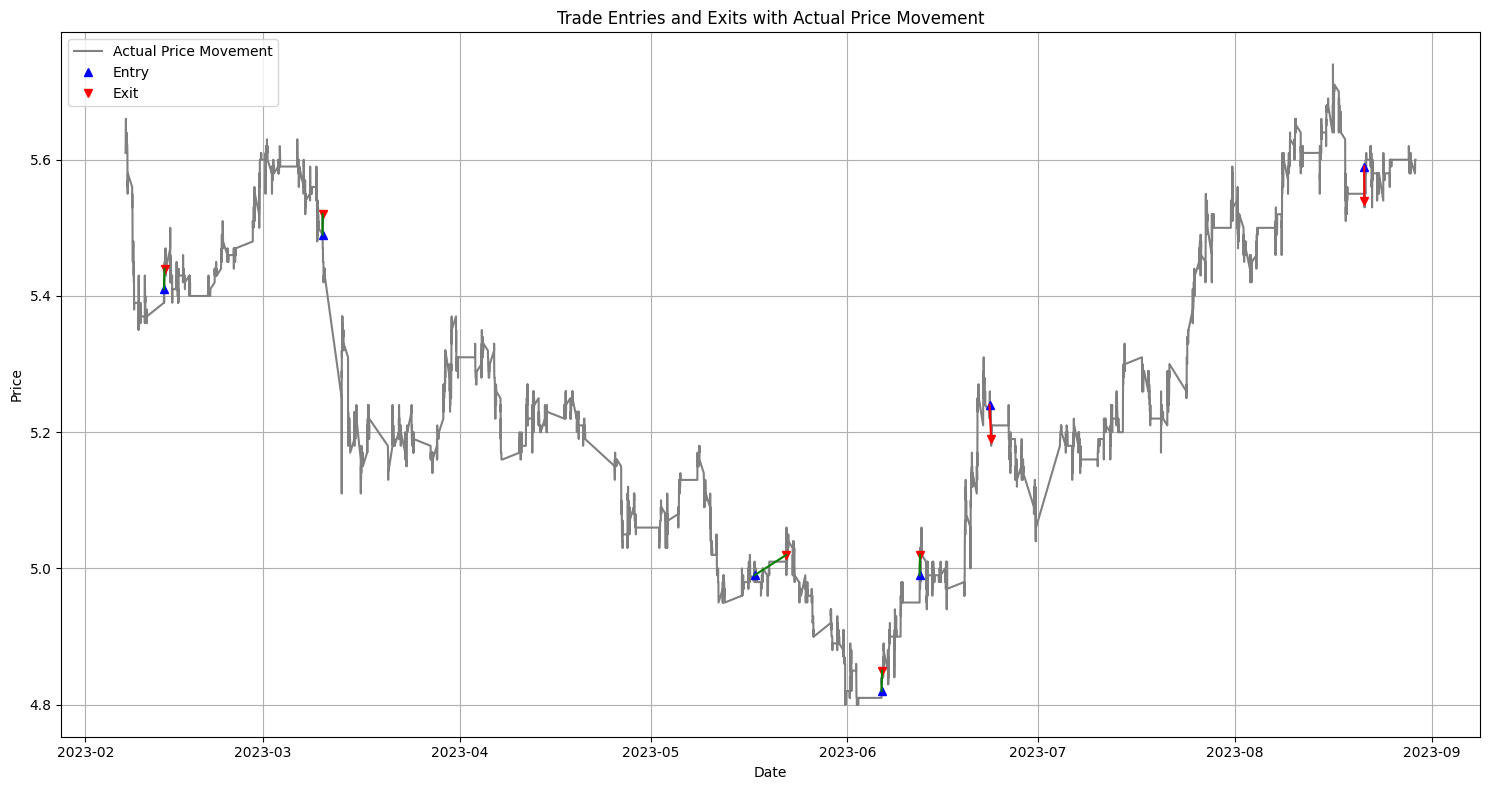

In [61]:
import matplotlib.pyplot as plt

# Convert string timestamps to datetime objects and set them as indices
trades_df['entry_timestamp'] = pd.to_datetime(trades_df['entry_timestamp'])
trades_df['exit_timestamp'] = pd.to_datetime(trades_df['exit_timestamp'])
trades_df = trades_df.set_index('entry_timestamp')  # Using entry_timestamp as index for plotting

# Convert UNIX timestamp (in milliseconds) to datetime and set it as the index
merged_df['time_msc'] = pd.to_datetime(merged_df['time_msc'], unit='ms')
merged_df = merged_df.set_index('time_msc')

# Plotting
plt.figure(figsize=(15, 8))

# Plotting 'last' column from merged_df
plt.plot(merged_df.index, merged_df['last'], color='grey', label='Actual Price Movement')

# Plot entry and exit points from trades_df
plt.plot(trades_df.index, trades_df['entry'], '^', color='blue', label='Entry')
plt.plot(trades_df['exit_timestamp'], trades_df['exit'], 'v', color='red', label='Exit')

# Indicating TP and SL with green and red lines respectively
for _, row in trades_df.iterrows():
    if row['type'] == 'TP':
        plt.plot([row.name, row['exit_timestamp']], [row['entry'], row['exit']], color='green')
    elif row['type'] == 'SL':
        plt.plot([row.name, row['exit_timestamp']], [row['entry'], row['exit']], color='red')

plt.title('Trade Entries and Exits with Actual Price Movement')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [62]:
result_df = result.copy()
#set end_time as index
result_df = result_df.set_index('end_time')
result_df

,volume_last_sum,start_time,buy_sum,sell_sum,time_diff,speed,speed_pct_change,signal
end_time,,,,,,,,
2023-02-07 09:00:33,1344122.0,2023-02-07 09:00:00,4,12,33.0,1.580362e+07,NaN,Hold
2023-02-08 09:07:58,235730.0,2023-02-08 09:00:00,2,13,478.0,1.913457e+05,-0.987892,Sell
2023-02-09 09:00:15,376332.0,2023-02-09 09:00:00,10,5,15.0,9.734454e+06,49.873654,Buy
2023-02-10 09:02:11,517825.0,2023-02-10 09:00:00,9,7,131.0,1.533711e+06,-0.842445,Hold
2023-02-13 09:00:33,304633.0,2023-02-13 09:00:00,12,5,33.0,3.581746e+06,1.335346,Buy
...,...,...,...,...,...,...,...,...
2023-08-23 09:16:13,55806.0,2023-08-23 09:00:00,2,13,973.0,2.225357e+04,-0.719590,Sell
2023-08-24 09:10:26,474298.0,2023-08-24 09:00:00,8,10,626.0,2.939738e+05,12.210185,Hold
2023-08-25 09:07:49,61404.0,2023-08-25 09:00:00,7,8,469.0,5.079904e+04,-0.827199,Hold


In [63]:
import pandas as pd



# Merge based on the indexes (datetime) of both tick_df and result_df using a left merge
merged_df = pd.merge(left=tick_df, right=result_df, left_index=True, right_index=True, how='left')

# Sorting by the index (which is the time from tick_df)
merged_df = merged_df.sort_index()
merged_df


,last,volume,time_msc,flags,volume_real,TICK_FLAG_BUY,TICK_FLAG_SELL,volume_last_sum,start_time,buy_sum,sell_sum,time_diff,speed,speed_pct_change,signal
2023-02-03 16:51:55,5.66,1000,1675443115081,312,1000.0,1,0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-03 16:53:30,5.66,1000,1675443210105,312,1000.0,1,0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-03 16:54:35,5.66,500,1675443275472,312,500.0,1,0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-07 09:00:00,5.61,179800,1675760400000,344,179800.0,0,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-07 09:00:01,5.63,10000,1675760401020,312,10000.0,1,0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-29 10:52:11,5.60,100,1693306331056,88,100.0,0,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-29 10:52:16,5.60,300,1693306336079,88,300.0,0,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-29 10:52:28,5.60,300,1693306348136,88,300.0,0,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-29 10:52:35,5.60,200,1693306355181,88,200.0,0,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
